# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

region = "CA"
model_data = df.loc[region]

## Create the model instance and sample

In [3]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 429 seconds.


## Summarize Model Output

In [4]:
result = summarize_inference_data(gm.inference_data)

In [5]:
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-15,1.103461,1.093855,0.926397,1.276178,1604.898456,1479.780984,1176.852327,2597.0,66186.0
2020-06-16,1.105886,1.089755,0.935844,1.291022,1641.001967,1499.953739,908.753364,2108.0,69573.0
2020-06-17,1.105256,1.096481,0.914378,1.275456,1678.585034,1521.536820,1720.401105,3455.0,60233.0
2020-06-18,1.108724,1.099184,0.901732,1.280072,1718.269000,1544.589669,1600.302498,4084.0,76542.0
2020-06-19,1.108852,1.103923,0.897744,1.285578,1760.297386,1569.187905,1595.114848,4317.0,81172.0
2020-06-20,1.107443,1.095383,0.876984,1.287143,1805.091817,1595.404903,1483.442260,3893.0,78710.0
2020-06-21,1.107759,1.093270,0.865680,1.282034,1852.712172,1623.310596,1596.073088,4515.0,84844.0
2020-06-22,1.110047,1.096306,0.875235,1.299675,1902.809522,1652.952376,1372.598658,4230.0,92430.0
2020-06-23,1.110956,1.096700,0.872252,1.317933,1955.756717,1684.349949,1765.934640,5019.0,85243.0


## Plot Model Output

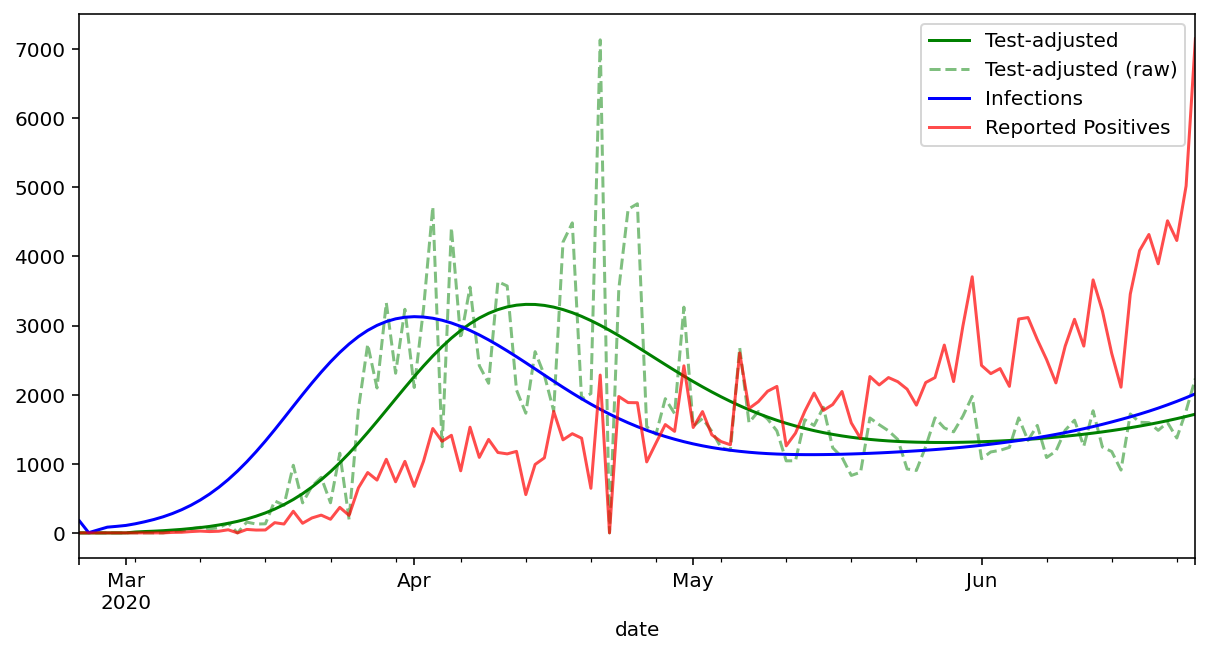

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

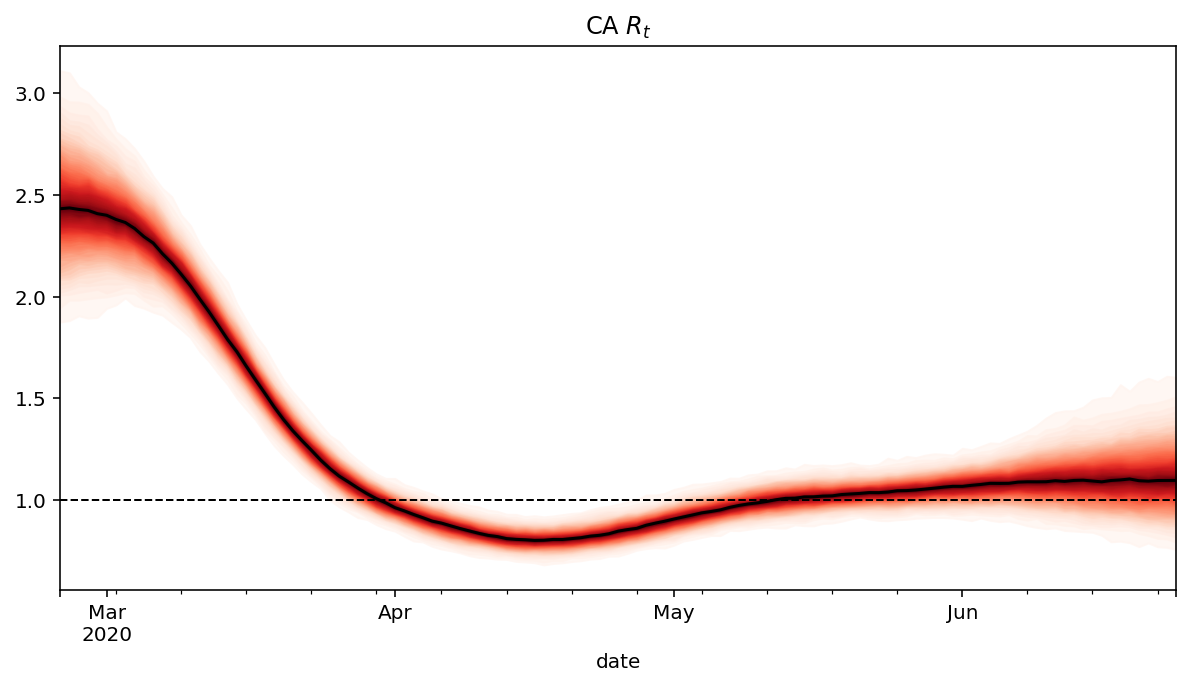

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')